In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import string
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install adabelief-pytorch==0.2.0
from adabelief_pytorch import AdaBelief
from torch.optim import *
import math
from sklearn.metrics import f1_score
!pip install pyarrow
import pandas as pd
!pip install torchviz
from torchviz import make_dot

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=cc123956d14bdbcd554e3548e6a231162345d9638c254261ce4663e1d54c2541
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transform, split='bymerge')
test_set = torchvision.datasets.EMNIST(root='./data', train=False, download=False, transform=transform, split='bymerge')

cuda:0



Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


# ResNet Model
Only use the first layer of ResNet.

In [3]:
class ResNet(nn.Module):
    
    def __init__(self, res, linear_dim=128, output_dim=47):
        
        super().__init__()
        self.resnet = res
        self.linear = nn.Linear(linear_dim, output_dim)
    
    def forward(self, x):
        
        x = self.resnet(x)
        x = self.linear(x.squeeze())
        
        return x.squeeze(1)

def get_resnet(state_dict=None):

  resnet18 = models.resnet18()
  emnist_cov2d = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  new_resnet18 = nn.Sequential(*[emnist_cov2d, resnet18.bn1, resnet18.relu, resnet18.maxpool] + list(resnet18.layer1) + [resnet18.avgpool])
  out_resnet = ResNet(new_resnet18, 64)

  if state_dict is not None:
    out_resnet.load_state_dict(state_dict)
  
  return out_resnet

# Train and Evaluate Algorithm
** Train model with different optimizers and evaluate it 

In [4]:
def evaluate(model, valid_dl):

  # we don't want to add evaluation related computation to computation graph
  with torch.no_grad():
    criterion = nn.CrossEntropyLoss()
    valid_loss_lst = torch.tensor([]).to('cuda')
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_valid, y_valid in valid_dl:
      X_valid = X_valid.to('cuda')
      y_valid = y_valid.to('cuda')
      pred = model(X_valid)
      valid_loss_lst = torch.cat((valid_loss_lst, criterion(pred, y_valid).view(-1)))
      predicted = pred.argmax(1).squeeze()
      y_pred_lst = torch.cat((y_pred_lst, predicted))
      y_true_lst = torch.cat((y_true_lst, y_valid))

  return valid_loss_lst.mean().item(), f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')


def train_res(**params):

  # define model and move it to gpu
  model = params['model']
  model.to('cuda')

  # define optimizer
  opt = params['optimizer'][0](model.parameters(), **params['optimizer'][1])

  # define data loader
  
  train_dl = DataLoader(params['train_data'], batch_size=params['batch_size'])
  valid_dl = DataLoader(params['test_data'], batch_size=params['batch_size'])

  # define loss
  criterion = torch.nn.CrossEntropyLoss()

  # start training
  valid_loss_lst = []
  train_loss_lst = []
  train_f1_lst = []
  valid_f1_lst = []

  for e in tqdm(range(params['epochs'] + 1)):
    train_losses = torch.tensor([]).to('cuda')
    correct = 0
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_train, y_train in train_dl:

      X_train = X_train.to('cuda')
      y_train = y_train.to('cuda')
        
      pred = model(X_train)
      loss = criterion(pred, y_train)

      # perform backward propagation
      loss.backward()

      # update model parameters and clear up gradient after update
      opt.step()
      opt.zero_grad()
      train_losses = torch.cat((train_losses, loss.view(-1)))

      with torch.no_grad():
        predicted = pred.argmax(1).squeeze()
        y_pred_lst = torch.cat((y_pred_lst, predicted))
        y_true_lst = torch.cat((y_true_lst, y_train))
      
        
    valid_loss, valid_f1 = evaluate(model, valid_dl)
    train_loss = train_losses.mean().item()
    train_f1 = f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')
    train_loss_lst.append(train_loss)
    valid_loss_lst.append(valid_loss)
    train_f1_lst.append(train_f1)
    valid_f1_lst.append(valid_f1)
    

    print(f'epoch: {e}, training loss: {train_loss}, training f1: {train_f1}, validation loss: {valid_loss}, validation f1: {valid_f1}')

  return model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst



In [5]:
my_resnet_adam = get_resnet()
default_params = my_resnet_adam.state_dict()
my_resnet_adam_belief = get_resnet(default_params)
my_resnet_padam = get_resnet(default_params)
my_resnet_SGD = get_resnet(default_params)

#Train ResNet with different optimizers and evaluate
** As mentioned, only use the first layer of ResNet

# Optimizer 1: SGD + Momentum
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
params = {
    'optimizer': (torch.optim.SGD, {'lr': 0.0005, 'momentum': 0.9}),
    'model': my_resnet_SGD,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}
model_SGD, train_loss_lst_SGD, valid_loss_lst_SGD, train_f1_lst_SGD, valid_f1_lst_SGD = train_res(**params)

  3%|▎         | 1/31 [02:50<1:25:11, 170.39s/it]

epoch: 0, training loss: 1.2380510568618774, training f1: 0.6810018741080793, validation loss: 0.6047092080116272, validation f1: 0.8188492387575974


  6%|▋         | 2/31 [05:38<1:22:04, 169.81s/it]

epoch: 1, training loss: 0.49346446990966797, training f1: 0.8460838591725268, validation loss: 0.43002229928970337, validation f1: 0.8608873567566173


 10%|▉         | 3/31 [08:26<1:19:00, 169.29s/it]

epoch: 2, training loss: 0.39502349495887756, training f1: 0.8694371371423004, validation loss: 0.3743441104888916, validation f1: 0.8742810966017038


 13%|█▎        | 4/31 [11:15<1:16:07, 169.16s/it]

epoch: 3, training loss: 0.3558635711669922, training f1: 0.8789466595599571, validation loss: 0.347007691860199, validation f1: 0.8810467405414234


 16%|█▌        | 5/31 [14:04<1:13:12, 168.93s/it]

epoch: 4, training loss: 0.33417364954948425, training f1: 0.8842695276903767, validation loss: 0.3309228718280792, validation f1: 0.8848465049904146


 19%|█▉        | 6/31 [16:51<1:10:13, 168.55s/it]

epoch: 5, training loss: 0.31997472047805786, training f1: 0.8880292062837067, validation loss: 0.31979015469551086, validation f1: 0.887812384481143


 23%|██▎       | 7/31 [19:41<1:07:35, 168.98s/it]

epoch: 6, training loss: 0.3096529543399811, training f1: 0.8908231747505487, validation loss: 0.3116424083709717, validation f1: 0.8900475400393731


 26%|██▌       | 8/31 [22:30<1:04:46, 168.96s/it]

epoch: 7, training loss: 0.3016294836997986, training f1: 0.8930612151327063, validation loss: 0.3052513301372528, validation f1: 0.8917582937166338


 29%|██▉       | 9/31 [25:21<1:02:06, 169.40s/it]

epoch: 8, training loss: 0.2950819730758667, training f1: 0.89471467134334, validation loss: 0.30022376775741577, validation f1: 0.8928156942307196


 32%|███▏      | 10/31 [28:09<59:10, 169.09s/it] 

epoch: 9, training loss: 0.28958839178085327, training f1: 0.8962578016196421, validation loss: 0.29597944021224976, validation f1: 0.8937011597018646


 35%|███▌      | 11/31 [30:57<56:13, 168.68s/it]

epoch: 10, training loss: 0.28486010432243347, training f1: 0.8975301318753116, validation loss: 0.29220524430274963, validation f1: 0.8946811894466271


 39%|███▊      | 12/31 [33:44<53:18, 168.35s/it]

epoch: 11, training loss: 0.28071898221969604, training f1: 0.8986348240229707, validation loss: 0.2891400158405304, validation f1: 0.8958159607300362


 42%|████▏     | 13/31 [36:32<50:26, 168.14s/it]

epoch: 12, training loss: 0.27704551815986633, training f1: 0.8994701489543394, validation loss: 0.28633949160575867, validation f1: 0.8964865073975052


 45%|████▌     | 14/31 [39:23<47:50, 168.86s/it]

epoch: 13, training loss: 0.27376800775527954, training f1: 0.9003298315595215, validation loss: 0.28388190269470215, validation f1: 0.8970281027827687


 48%|████▊     | 15/31 [42:10<44:56, 168.54s/it]

epoch: 14, training loss: 0.27079927921295166, training f1: 0.9012095734254914, validation loss: 0.28170815110206604, validation f1: 0.8976986494502377


 52%|█████▏    | 16/31 [44:58<42:06, 168.41s/it]

epoch: 15, training loss: 0.2680900990962982, training f1: 0.9019374380312122, validation loss: 0.2798425257205963, validation f1: 0.8981198903054426


 55%|█████▍    | 17/31 [47:45<39:08, 167.75s/it]

epoch: 16, training loss: 0.2656031548976898, training f1: 0.9026036920502285, validation loss: 0.27802735567092896, validation f1: 0.8986958726992942


 58%|█████▊    | 18/31 [50:33<36:22, 167.92s/it]

epoch: 17, training loss: 0.26329711079597473, training f1: 0.903248454004115, validation loss: 0.2764890491962433, validation f1: 0.899108516802352


 61%|██████▏   | 19/31 [53:22<33:38, 168.19s/it]

epoch: 18, training loss: 0.26116612553596497, training f1: 0.9038975143710275, validation loss: 0.2751167416572571, validation f1: 0.8994437901360866


 65%|██████▍   | 20/31 [56:12<30:55, 168.72s/it]

epoch: 19, training loss: 0.2591720223426819, training f1: 0.9043531461517741, validation loss: 0.2737584114074707, validation f1: 0.8996501121876155


 68%|██████▊   | 21/31 [59:02<28:12, 169.27s/it]

epoch: 20, training loss: 0.2572941184043884, training f1: 0.9049062086277746, validation loss: 0.27252399921417236, validation f1: 0.9000455627863793


 71%|███████   | 22/31 [1:01:52<25:24, 169.39s/it]

epoch: 21, training loss: 0.25554296374320984, training f1: 0.9054076901474643, validation loss: 0.2713959515094757, validation f1: 0.90021749782932


 74%|███████▍  | 23/31 [1:04:41<22:34, 169.34s/it]

epoch: 22, training loss: 0.2538736164569855, training f1: 0.9058117409718999, validation loss: 0.27035588026046753, validation f1: 0.9003464491115256


 77%|███████▋  | 24/31 [1:07:29<19:42, 168.99s/it]

epoch: 23, training loss: 0.25229471921920776, training f1: 0.9063031928611957, validation loss: 0.2694977819919586, validation f1: 0.9004582068894371


 81%|████████  | 25/31 [1:10:20<16:56, 169.44s/it]

epoch: 24, training loss: 0.2508091628551483, training f1: 0.906672856381424, validation loss: 0.26863452792167664, validation f1: 0.9006731256931132


 84%|████████▍ | 26/31 [1:13:10<14:08, 169.66s/it]

epoch: 25, training loss: 0.24938644468784332, training f1: 0.907105563292699, validation loss: 0.26781806349754333, validation f1: 0.9007934802231717


 87%|████████▋ | 27/31 [1:15:59<11:17, 169.36s/it]

epoch: 26, training loss: 0.24802924692630768, training f1: 0.9075425686169999, validation loss: 0.2671981453895569, validation f1: 0.9007676899667306


 90%|█████████ | 28/31 [1:18:48<08:27, 169.21s/it]

epoch: 27, training loss: 0.24673320353031158, training f1: 0.9078305622897359, validation loss: 0.26655253767967224, validation f1: 0.9008192704796129


 94%|█████████▎| 29/31 [1:21:37<05:38, 169.28s/it]

epoch: 28, training loss: 0.24547895789146423, training f1: 0.9081572416797051, validation loss: 0.2659539580345154, validation f1: 0.9007934802231717


 97%|█████████▋| 30/31 [1:24:26<02:49, 169.19s/it]

epoch: 29, training loss: 0.24426354467868805, training f1: 0.908499681917436, validation loss: 0.26542407274246216, validation f1: 0.9009052380010832


100%|██████████| 31/31 [1:27:14<00:00, 168.85s/it]

epoch: 30, training loss: 0.2431037425994873, training f1: 0.9088191972856955, validation loss: 0.26492905616760254, validation f1: 0.9010599795397299


In [ ]:
import pandas as pd
sgd_df = pd.DataFrame(data={'train_loss': train_loss_lst_SGD, 
                            'valid_loss': valid_loss_lst_SGD, 
                            'train_f1': train_f1_lst_SGD, 
                            'valid_f1': valid_f1_lst_SGD, 
                            'category': ['sgd']*len(train_loss_lst_SGD)})

sgd_df.to_parquet('./sgd_results.parquet')

# Optimizer 2: Adam
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
params = {
    'optimizer': (torch.optim.Adam, {'lr': 0.0005}),
    'model': my_resnet_adam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}
model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst = train_res(**params)

In [ ]:
adam_df = belif_df = pd.DataFrame(data={'train_loss': train_loss_lst, 
                            'valid_loss': valid_loss_lst, 
                            'train_f1': train_f1_lst, 
                            'valid_f1': valid_f1_lst, 
                            'category': ['adam']*len(train_loss_lst_SGD)})

adam_df.to_parquet('./adam_results.parquet')

# Optimizer 3: AdaBelief
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
params = {
    'optimizer': (AdaBelief, {'lr': 0.0005}),
    'model': my_resnet_adam_belief,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_belief, train_loss_lst_belief, valid_loss_lst_belief, train_f1_lst_belief, valid_f1_lst_belief = train_res(**params)

In [ ]:
belif_df = pd.DataFrame(data={'train_loss': train_loss_lst_belief, 
                            'valid_loss': valid_loss_lst_belief, 
                            'train_f1': train_f1_lst_belief, 
                            'valid_f1': valid_f1_lst_belief, 
                            'category': ['belief']*len(train_loss_lst_SGD)})

belif_df.to_parquet('./belif_results.parquet')

# Optimizer 4: Padam
** Training usually takes over 10 hours. Results are saved in the .parquet file 

In [ ]:
class Padam(Optimizer):
    """Implements Partially adaptive momentum estimation (Padam) algorithm.
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-1)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        partial (float, optional): partially adaptive parameter
    """

    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True, partial = 1/4):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, partial = partial)
        super(Padam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                partial = group['partial']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom**(partial*2))
                
        return loss

In [ ]:
params = {
    'optimizer': (Padam, {'lr': 0.0005}),
    'model': my_resnet_padam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_padam, train_loss_lst_padam, valid_loss_lst_padam, train_f1_lst_padam, valid_f1_lst_padam = train_res(**params)

In [ ]:
padam_df = pd.DataFrame(data={'train_loss': train_loss_lst_padam, 
                            'valid_loss': valid_loss_lst_padam, 
                            'train_f1': train_f1_lst_padam, 
                            'valid_f1': valid_f1_lst_padam, 
                            'category': ['padam']*len(train_loss_lst_SGD)})

padam_df.to_parquet('./padam_results.parquet')

# Combine results of 4 optimizors into one .parquet file

In [ ]:
full_df = pd.concat([belief_df, adam_df, padam_df, sgd_df])
full_df.to_parquet('./full_df.parquet')

# Load the training/evaluating results trained previously
** You could skip this section if you run all the code in one time. Otherwise, you could upload the results you trained previously and load them. In github, trained results are provided.

In [ ]:
import pandas as pd
sgd_df = pd.read_parquet('./sgd_results.parquet', engine='pyarrow')
adam_df = pd.read_parquet('./adam_results.parquet', engine='pyarrow')
belif_df = pd.read_parquet('./belif_results.parquet', engine='pyarrow')
padam_df = pd.read_parquet('./padam_results.parquet', engine='pyarrow')
full_df = pd.read_parquet('./full_df.parquet', engine='pyarrow')

# Draw diagrams
- training cross-entropy loss curves of 4 optimizers
- validation cross-entropy loss curves of 4 optimizers
- training f1 scores curves of 4 optimizers
- validation f1 scores curves of 4 optimizers

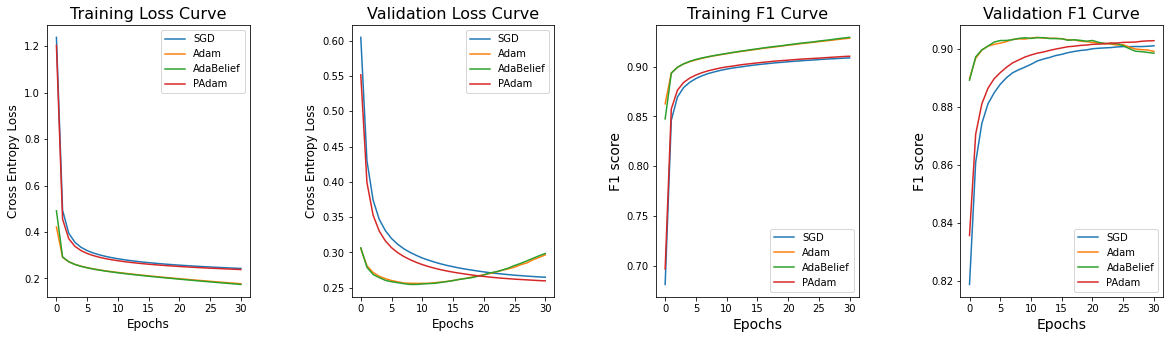

In [ ]:
from matplotlib.pyplot import MultipleLocator
epo=[i for i in range(31)]
plt.figure(figsize=(20, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.5, hspace=0.5)
plt.subplot(141)
plt.title("Training Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['train_loss'], label="SGD")
plt.plot(epo, adam_df['train_loss'], label="Adam")
plt.plot(epo, belif_df['train_loss'], label="AdaBelief")
plt.plot(epo, padam_df['train_loss'], label="PAdam")

x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()


plt.subplot(142)

plt.title("Validation Loss Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_loss'], label="SGD")
plt.plot(epo, adam_df['valid_loss'], label="Adam")
plt.plot(epo, belif_df['valid_loss'], label="AdaBelief")
plt.plot(epo, padam_df['valid_loss'], label="PAdam")
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Cross Entropy Loss", fontsize=12)
plt.legend()
plt.subplot(143)
plt.title("Training F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['train_f1'], label="SGD")
plt.plot(epo, adam_df['train_f1'], label="Adam")
plt.plot(epo, belif_df['train_f1'], label="AdaBelief")
plt.plot(epo, padam_df['train_f1'], label="PAdam")

x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()


plt.subplot(144)

plt.title("Validation F1 Curve", fontsize=16)
plt.plot(epo, sgd_df['valid_f1'], label="SGD")
plt.plot(epo, adam_df['valid_f1'], label="Adam")
plt.plot(epo, belif_df['valid_f1'], label="AdaBelief")
plt.plot(epo, padam_df['valid_f1'], label="PAdam")
x_major_locator=MultipleLocator(5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.legend()
plt.savefig('./res_images.png')
plt.show()

# Draw the structure of model

In [ ]:
!pip install torchviz
from torchviz import make_dot
my_model = get_resnet()
out = my_model(torch.randn(64,1,224,224))
make_dot(out, dict(my_model.named_parameters())).render('model', format='png')

'model.png'